In [2]:
from astropy.io import fits
from astropy.wcs import WCS
from glob import glob
import matplotlib.pyplot as plt
import numpy as np

from matplotlib.colors import LogNorm

In [3]:
rootPath = "/home/daraghhollman/Main/CometsThesis/"

# Defining Basic Image Stacking

In [4]:
def StackImages(imagePathsList):
    stackedImage = np.zeros(np.shape(fits.open(imagePathsList[0])[0].data))

    for path in imagePathsList:
        fitsFile = fits.open(path)

        image = fitsFile[0].data

        stackedImage += image

    return stackedImage  

['/home/daraghhollman/Main/CometsThesis/Comet 2019/CroppedImages/march09/R/ucdM_0432.fits', '/home/daraghhollman/Main/CometsThesis/Comet 2019/CroppedImages/march09/R/ucdM_0435.fits', '/home/daraghhollman/Main/CometsThesis/Comet 2019/CroppedImages/march09/R/ucdM_0437.fits', '/home/daraghhollman/Main/CometsThesis/Comet 2019/CroppedImages/march09/R/ucdM_0439.fits']


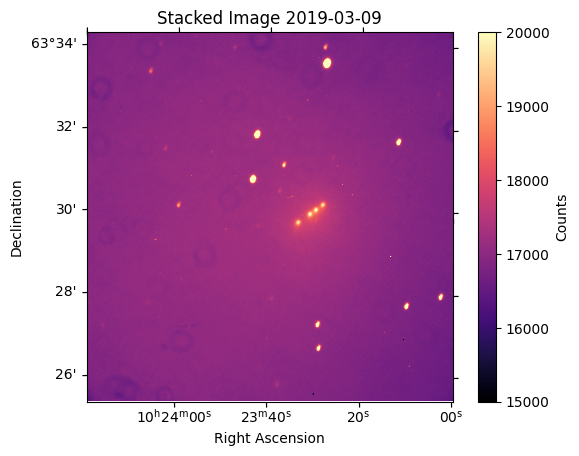

In [20]:
croppedImages = glob(rootPath + "Comet 2019/CroppedImages/march09/R/*")
croppedImages.sort()
print(croppedImages)

stackedImage = StackImages(croppedImages)

wcsFile = rootPath + "Comet 2019/wcs20190309.fits"
wcs = WCS(fits.open(wcsFile)[0].header)
plt.subplot(projection=wcs)

# R: vmin=15000, vmax=20000

plt.imshow(stackedImage, vmin=15000, vmax=20000, cmap="magma", label="Counts")
plt.colorbar(label="Counts")
plt.title("Stacked Image 2019-03-09")
plt.xlabel("Right Ascension")
plt.ylabel("Declination")
plt.gca().invert_yaxis()

# Updating stacking to work with Photutils
### Source detection with Photutils

In [21]:
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std
from dataclasses import dataclass
from astropy.coordinates import SkyCoord, Angle
from astropy import units as u
from photutils.aperture import aperture_photometry, CircularAperture, CircularAnnulus
import matplotlib.patches as patches
from astropy.nddata import Cutout2D

In [23]:
data = fits.open(rootPath + "Comet 2019/CroppedImages/march09/R/ucdM_0432.fits")[0].data

wcsFilePath = rootPath + "Comet 2019/wcs20190309.fits"
wcs = WCS(fits.open(wcsFilePath)[0].header)

In [24]:
def SearchStars(image, fwhm=8., threshold=4, showPlot=False):

    medianAbsoluteDeviation = mad_std(image)
    daofind = DAOStarFinder(fwhm=fwhm, threshold=threshold*medianAbsoluteDeviation)
    sources = daofind(image)

    if (showPlot):
        plt.subplot(projection=wcs)
        plt.imshow(image)
        plt.scatter(sources['xcentroid'], sources['ycentroid'], alpha=0.5, color="orange")
        plt.xlabel("Right Ascension")
        plt.ylabel("Declination")
        plt.gca().invert_yaxis()

    return sources

In [25]:
def FindComet(image, bounds, showPlot=False):
    # Seaches the image within a bounding box for objects bright enough to be the comet and returns the most likely choice for the comet centre in pixel coordinates

    lowerX, upperX, lowerY, upperY = bounds

    # Get all star-like objects
    sources = SearchStars(image, showPlot=showPlot)

    # Plot rectangle bounds
    if showPlot:
        plt.plot([lowerX, upperX, upperX, lowerX, lowerX], [lowerY, lowerY, upperY, upperY, lowerY], color="white")

    potentialComets = []

    for source in sources:
        
        if (source["xcentroid"] > lowerX and source["xcentroid"] < upperX
            and source["ycentroid"] > lowerY and source["ycentroid"] < upperY):

            potentialComets.append(source)


    # If there's more than one option, find the 'most likely'
    # Here we define the most likely as the source closest to the centre of the bounding box
    if len(potentialComets) > 1:

        boundingBoxCentre = ( (upperX + lowerX) / 2, (upperY + lowerY) / 2 )

        shortestDistance = (upperX - lowerX) * 20
        mostLikelyID = None

        for i, source in enumerate(potentialComets):

            distance = np.sqrt((boundingBoxCentre[0] - source["xcentroid"])**2 + (boundingBoxCentre[1] - source["ycentroid"])**2 )

            if distance < shortestDistance:
                shortestDistance = distance
                mostLikelyID = i
            else:
                continue

        if showPlot:
            plt.scatter(potentialComets[mostLikelyID]["xcentroid"], potentialComets[mostLikelyID]["ycentroid"])

        return potentialComets[mostLikelyID]

    else:

        if showPlot:
            plt.scatter(potentialComets[mostLikelyID]["xcentroid"], potentialComets[mostLikelyID]["ycentroid"])
        
        return potentialComets

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64
15,487.5840028316167,442.30194325364494,0.4054639114591122,-0.2710739824568175,0.12779621663167906,121,0.0,6701.0,15.584777530927878,-2.981751518011132


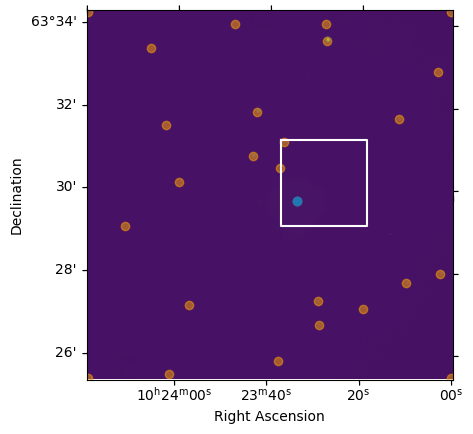

In [26]:
FindComet(data, [450, 650, 300, 500], showPlot=True)

In [27]:
def StackComets(imagePaths, bounds, size):
    # Takes paths to consecutive images and stacks them based on the comet's centrepoint

    # First we must load each image and find the comet using FindComet()
    cometPositions = []

    cutouts = []

    stackedImages =[]

    for imagePath in imagePaths:

        image = fits.open(imagePath)[0].data

        comet = FindComet(image, bounds)
        cometX = comet["xcentroid"]
        cometY = comet["ycentroid"]

        # Create and save new fits file centred on the comet
        cutout = Cutout2D(image, (cometX, cometY), size * (bounds[1] - bounds[0]), wcs=wcs)

        cutouts.append(cutout)

    for cutout in cutouts:
        
        stackedImages.append(cutout.data)

    stackedImage = np.median(stackedImages, axis=0)
    
    return stackedImage

FITS image saved to: /home/daraghhollman/Main/CometsThesis/Comet 2019/images/march09_stacked_R_2.5.fits


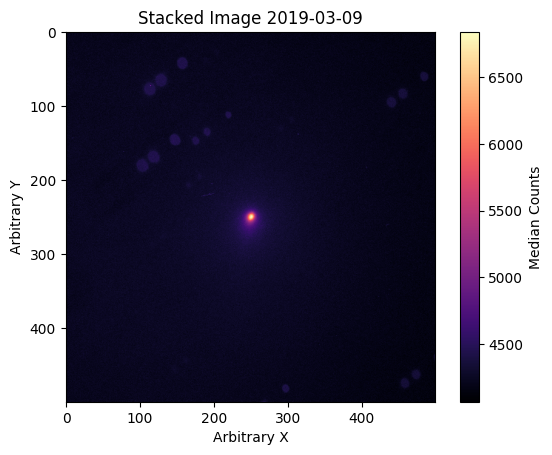

In [35]:
croppedImages = glob(rootPath + "Comet 2019/CroppedImages/march09/R/*")
croppedImages.sort()

stackedImage = StackComets(croppedImages, [450, 650, 300, 500], 2.5)
plt.imshow(stackedImage, cmap="magma")
plt.title("Stacked Image 2019-03-09")
plt.colorbar(label="Median Counts")
plt.xlabel("Arbitrary X")
plt.ylabel("Arbitrary Y")


newFits = fits.PrimaryHDU()
newFits.data = stackedImage

outputPath = rootPath + "Comet 2019/images/march09_stacked_R_2.5.fits"
newFits.writeto(outputPath, overwrite=True)
print(f"FITS image saved to: {outputPath}")